<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANWithPyTorch/blob/main/07_gan_mnist_first_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # 이미지 목표(레이블)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 0-255의 이미지를 0-1로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [4]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/mnist_data/mnist_train.csv')

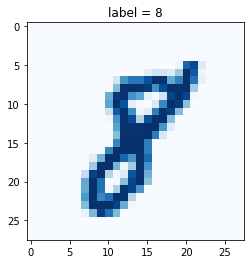

In [14]:
mnist_dataset.plot_image(17)

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 설정
        self.loss_function = nn.MSELoss()

        # 옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망의 결과 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [16]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [17]:
# 판별기 테스트

D = Discriminator()


for label, image_data_tensor, target_tensor in mnist_dataset:
  # 실제 데이터
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


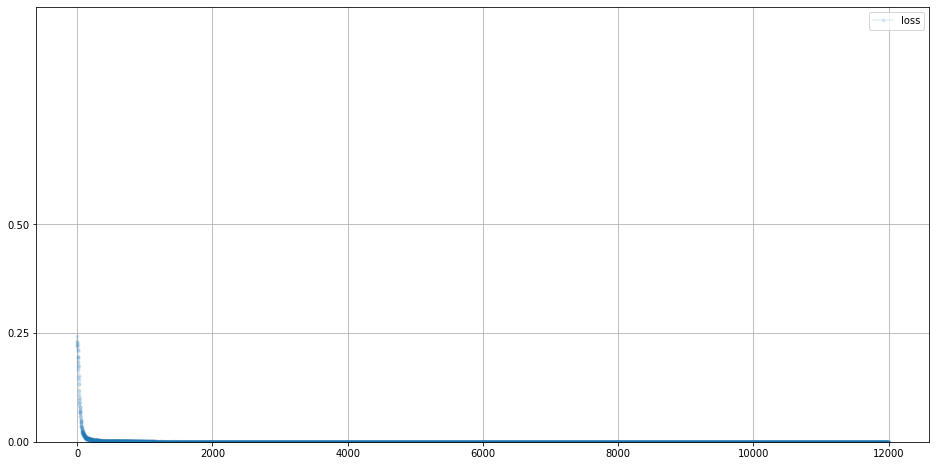

In [18]:
D.plot_progress()

*판별기를 훈련시켰으니 데이터를 넣어본다.*

In [19]:
# 가짜와 진짜를 판별할 수 있는지 판별기를 직접 구동

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

0.9872697591781616
0.992090106010437
0.9969415068626404
0.9958051443099976
0.007422749884426594
0.006064373068511486
0.004847511649131775
0.007667895406484604


In [20]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # SGD 옵티마이저 생성
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기에 값 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

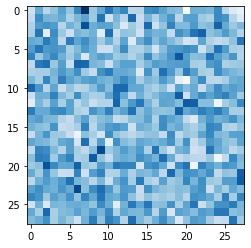

In [21]:
# 생성기 테스트

G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation = 'none', cmap = 'Blues')

In [23]:
# GAN 훈련
%%time

D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:

  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 49s, sys: 3.22 s, total: 3min 52s
Wall time: 3min 57s


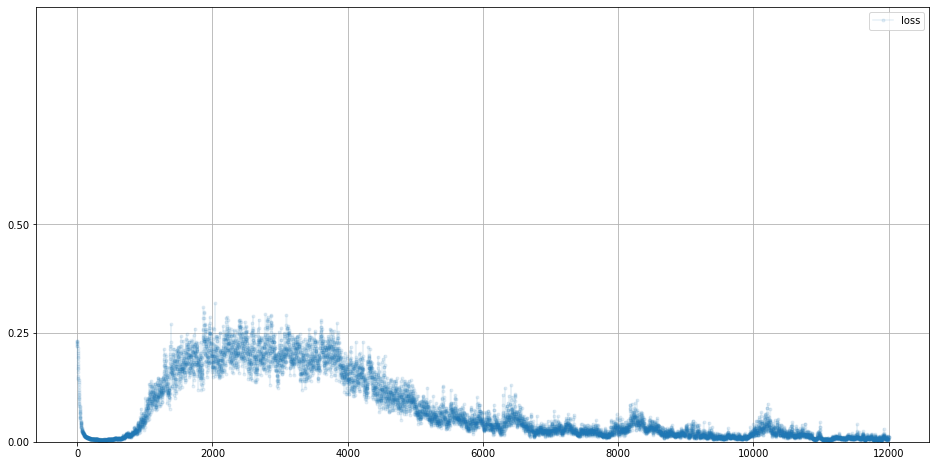

In [24]:
D.plot_progress()

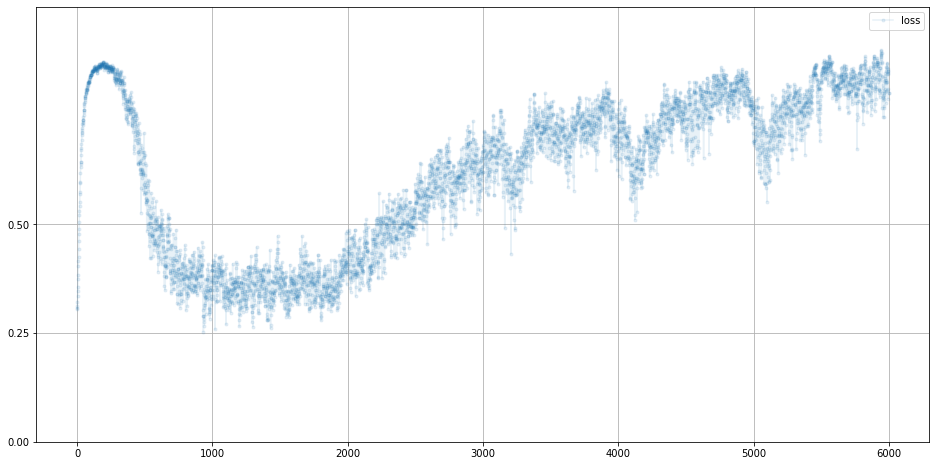

In [25]:
G.plot_progress()

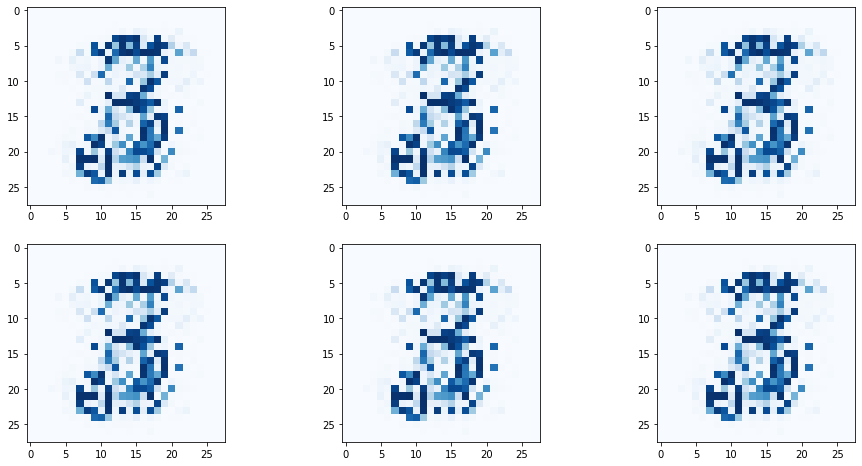

In [26]:
# 생성기가 만드는 이미지


f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

**GAN 훈련 성능 향상하기**

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 설정
        self.loss_function = nn.BCELoss()

        # 옵티마이저 설정
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망의 결과 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [6]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [7]:
%%time
# 판별기가 임의의 노이즈로부터 실제 데이터를 구별할수 있는지 확인

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 6s, sys: 3.6 s, total: 4min 10s
Wall time: 4min 9s


In [13]:
D.plot_progress()

TypeError: ignored